# LunarLander-v2 DQN

Applying the stuff I already learned to a new enviornment.

To get the 2D enviornments to work:

conda install swig

pip install Box2D

Getting to know the enviornment

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Action is two real values vector from -1 to +1. First controls main engine, -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power. Second value -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off.

Na prvi uč v dokumentaciji je STATE sledeč:
* Pos x
* Pos y
* Velocity x
* Velocity y
* self.lander.angle
* (something to do with Angular velocity)
* 1 if leg0 has ground contact, else 0
* 1 if leg1 has ground contact, else 0

Na prvi uč so ACTIONS:
* 0 -> do nothing
* 1 -> right engine
* 2 -> main engine
* 3 -> left engine

In [ ]:
import gym
from time import time

env = gym.make("LunarLander-v2")
env = gym.wrappers.Monitor(env, "./videos/"+str(int(time()))+"/", video_callable=lambda episode_id: episode_id%100==0)
env._max_episode_steps = 20 # changes the max steps in an episode
#env.reset()

print("Observation space: ", env.observation_space.shape)
print("Action space: ", env.action_space.n)

In [ ]:
env._max_episode_steps

In [ ]:
for episode in range(10):
    done = False
    state = env.reset()
    print("\n\nEPISODE: ", episode)
    print("== State: ", state)
    
    total_reward = 0
    steps = 0
    while not done:
        env.render()
        action = 2#env.action_space.sample()
        #print("== Making action: ", action)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1
        
        if steps >= env._max_episode_steps:
            print("MAX STEPS")
            done = True
            reward = -100
            env.stats_recorder.save_complete()
            env.stats_recorder.done = True
        
        print("Stats recorder: ", env.stats_recorder.done)
        print("== Steps: ", steps)
        print(f"== Next state: {next_state}")
        print(f"== Reward: {reward}")
        print(f"== Done: {done}")
        #print(f"== Info: {info}")
        print()
        
    #print("Steps: ", steps)
    #print(reward)
env.close()

# DQN Agent

In [1]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline

class DQNPlotting:
    '''
    Class used to graphically present different aspects of DQN Learning.
    
    One of the things I would like to get a better look into is:
        - Which states were most visited
        - Which states were most used while training
        
    Class works by creating Axes. It periodically draws over the Axes or redraws the whole thing.
    '''
    
    def __init__(self):
        rows = 1
        columns = 2
        self.fig, self.ax = plt.subplots(rows, columns, figsize=(15, 10))
        
        
        
    def draw(self, graph_data, data_clear=False):
        '''
        PARAMS
            data     <dictionary>   Dictionary, where "key" is the axes we want to draw the data. Value is the data we want to plot
                                        Example:
                                            {(1,2): {
                                                "x": [1,2,3],
                                                "y": [4,5,6]
                                                }
                                                "draw_mode": "scatter"
                                                "x_label": "num_of_episodes",
                                                "y_label": "reward"
                                            }
            clear    <boolean>      If True, it will clear the Axes before drawing.
        
        RETURNS
        
        '''
        
        
        if data_clear:
            print("ADD FUNCTIONALITY WHEN WE WANT TO CLEAR AXES")
            pass # TO-DO add the clearing part of code
        
        for key, value in graph_data.items():
            if value["draw_mode"] == "scatter":
                self.ax[key].scatter(value["x"], value["y"], c=value["c"], alpha=0.005)
                self.ax
            elif value["draw_mode"] == "plot":
                self.ax[key].plot(value["x"], value["y"], c=value["c"])
            self.ax[key].set_xlabel(value["x_label"])
            self.ax[key].set_ylabel(value["y_label"])
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
    

In [3]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from time import time
import random
import numpy as np


class DQNModel:
    '''
    Class that manages the neural network of DQN agent.
    Through it the models parameters are controled:
        * number of layers
        * nodes in each layer
        * activation functions
        * optimizers
        * etc...
    '''
    def __init__(self):
        '''
        
        '''
        pass
    
    def create_model(self, input_shape, action_space):
        '''
        Method used to create the model.
        
        PARAMS:
            input_shape    <integer>    the number of input neurons the network needs
            action_space   <integer>    number of output neuron the network needs
            
        RETURNS:
            models    <tensorflow neural network>    this holds the neural network model
            
        '''
        model = Sequential()
        
        model.add(Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform'))
        model.add(Dense(256, activation="relu", kernel_initializer='he_uniform'))
        model.add(Dense(64, activation="relu", kernel_initializer='he_uniform'))
        model.add(Dense(action_space, activation="linear", kernel_initializer='he_uniform'))
        
        model.compile(loss="mse", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=['accuracy'])

        model.summary()
        return model


    

In [4]:
import random
import numpy as np
import pandas as pd
from collections import deque

class DQNMemory:
    '''
    Class used to manage the DQN Memory.
    '''
    
    def __init__(self, 
                 good_memory,
                 max_good_episodes = 5, # how many good episodes can be in the good memory
                 max_bad_episodes = 5,
                 
                ):
        self.setup_memory(good_memory)
        self.max_good_episodes = max_good_episodes
        self.max_bad_episodes = max_bad_episodes
        
        self.moments_gathered = 0 # every moment we add, this gets +1. Its a stand-in for checking when to start training
    
    
    def setup_memory(self, good_memory=None, bad_memory=None):
        if good_memory != None:
            self.good_memory = good_memory         # Holds a few full episodes in which I won by hand
        elif good_memory == None:
            self.good_memory = {}
        
        if bad_memory != None:
            self.bad_memory = bad_memory
        elif bad_memory == None:
            self.bad_memory = {}
        
        self.random_memory = deque(maxlen=1000) # This will be the random memory from episodes
        self.episode_memory = []   # This holds the memory of 1 episode. So that I can save it if we WIN
        
        self.memory = np.empty(shape=(0,5))
    
    def add_memory(self, state, action, reward, next_state, done):
        '''
        Adds a new memory to the overall memory.
        
        PARAMS:
        
        RETURNS:
        '''
        self.random_memory.append(np.array([state, action, reward, next_state, done]))
        self.episode_memory.append(np.array([state, action, reward, next_state, done]))
        self.moments_gathered += 1
        
        
    def reset_episode_memory(self):
        self.episode_memory = []
    
    
    def add_good_episode_to_memory(self, ep_reward):
        good_episode = np.array(self.episode_memory)
        
        print()
        print("Good episodes: ", list(self.good_memory.keys()), "/", self.max_good_episodes)
        
        if len(self.good_memory.keys()) < self.max_good_episodes:
            self.good_memory[ep_reward] = good_episode
        elif ep_reward > min(self.good_memory.keys()):
            del self.good_memory[min(self.good_memory.keys())]
            self.good_memory[ep_reward] = good_episode # tko se nadomesti najmanjši reward z novim episodičnim spominom
            
    def add_bad_episode_to_memory(self, ep_reward):
        bad_episode = np.array(self.episode_memory)
        
        print("Bad episodes: ", list(self.bad_memory.keys()), "/", self.max_bad_episodes)

        if len(self.bad_memory.keys()) < self.max_bad_episodes:
            self.bad_memory[ep_reward] = bad_episode
        elif ep_reward < max(self.bad_memory.keys()):
            del self.bad_memory[max(self.bad_memory.keys())]
            self.bad_memory[ep_reward] = bad_episode # tko se nadomesti najmanjši reward z novim episodičnim spominom
            
            
    def get_minibatch(self, batch_size):
        '''
        Function that returns a minibatch from the overall memory.
        
        
        
        PARAMS:
            batch_size    <integer>    the size of the minibatch
            
        RETURNS:
            minibatch     <>
        '''
        
        # Select one of the good_episode from good_memory.
        # The higher the total_reward it got, the higher the chances to be choosen
        # From that good_episode, get the minibatch
        good_rewards = np.array(list(self.good_memory.keys())) # get the good rewards
        #normalize the good_rewards to fall between -1 and 1. If they are not normalized than extreme values will fuck with the math..
        # normalization can be done on a bigger interval, but -1 to 1 is probably good..
        
        norm_good_rewards = 2* ((good_rewards-np.min(good_rewards))/(np.max(good_rewards)-np.min(good_rewards))) - 1
        good_probabilities = np.exp(norm_good_rewards)/np.sum(np.exp(norm_good_rewards)) # e^x/sum(e^x)
        good_probabilities[-1] = 1-sum(good_probabilities[:-1])
        good_choice = np.random.choice(good_rewards, 1, p=good_probabilities)[0] # Function returns array, even if with only 1 number
        # Get moments from self.good_memory
        good_memory = np.empty(shape=(0, 5)) # should not be hardcoded like this
        for moment in self.good_memory[good_choice]:
            moment = np.reshape(moment, newshape=(1, moment.shape[0]))
            good_memory = np.append(good_memory, moment, axis=0)
            
        # Do the same probabilites for the bad memory
        bad_rewards = np.array(list(self.bad_memory.keys()))
        # normalize the bad rewards between -1 and 1
        norm_bad_rewards = 2* ((bad_rewards-np.min(bad_rewards))/(np.max(bad_rewards)-np.min(bad_rewards))) - 1
        bad_probabilities = np.exp(norm_bad_rewards)/np.sum(np.exp(norm_bad_rewards)) # we are taking the best bad_episode (-200, -300, -400) we would take -200.. not really what i wanted but ok. I wanted to take the worst (-400)
        bad_probabilities[-1] = 1-sum(bad_probabilities[:-1])
        bad_choice = np.random.choice(bad_rewards, 1, p=bad_probabilities)[0] # Function returns array, even if with only 1 number
        # Get moments from self.bad_memory
        bad_memory = np.empty(shape=(0, 5)) # should not be hardcoded like this
        for moment in self.bad_memory[bad_choice]:
            moment = np.reshape(moment, newshape=(1, moment.shape[0]))
            bad_memory = np.append(bad_memory, moment, axis=0)
        
        random_memory = np.empty(shape=(0, 5)) # should not be hardcoded like this
        random_memory = np.append(random_memory, self.random_memory, axis=0)
        
        minibatch = np.empty(shape=(0,5)) # should not be hardcoded
        
        np.random.shuffle(good_memory)
        minibatch = np.append(minibatch, good_memory[:int(batch_size/3)], axis=0)
        
        np.random.shuffle(bad_memory)
        minibatch = np.append(minibatch, bad_memory[:int(batch_size/3)], axis=0)
        
        np.random.shuffle(random_memory)
        
        minibatch = np.append(minibatch, random_memory[:int(batch_size/3)], axis=0) # We contantly go through good and bad episodes. But there is a WHOLE lot in between. Im guessing.. maybe I don't need this much moments from random memory
        
        return minibatch

In [5]:
import random
import numpy as np
import os
import pickle # for quick saving of memory


class DQNAgent:
    '''
    Class used to manage the DQN Agent.
    
    '''
    
    def __init__(self,
                 state_size,
                 action_size,
                 good_memory=None,      # I played some rounds to win and get the "good path"
                 gamma=0.95,         # reward discount rate
                 epsilon=1.0,        # exploration rate
                 epsilon_min=0.001,
                 epsilon_decay=0.999,
                 batch_size=64,
                 train_start=1000,   # when we have this many individual memories, the training can start
                 
                ):
        '''
        
        PARAMS:
            state_size    <integer>    Defines how many input neurons we need.
            action_size   <integer>    How many different actions we can make. Defines how many output neurons we need.
            gamma         <float>      The reward discount rate. Value is used in the newQ value calculation.
            epsilon       <float>      The exploration. If a random number is lower than epsilon we will make a random action.
            epsilon_min   <float>      The minimal value epsilon can take.
            epsilon_decay <float>      Value used when decaying the epsilon.
            batch_size    <integer>    The size of the minibatch we take from memory when training.
            train_start   <integer>    The amount of individual memories we want to have before we start training.
            
        RETURNS:
            
        '''
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.EPISODES = EPISODES
        self.memory = DQNMemory(good_memory=good_memory)
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.batch_size = batch_size
        self.train_start = train_start

        # create main model
        self.model = DQNModel().create_model(input_shape=(self.state_size,), 
                              action_space = self.action_size)
        
        
    def load(self, path):
        '''
        Loads the pre-existing model. 
        (Does the model need to be the same architecture or can it be anything?)
        
        PARAMS:
            path   <string>    path to the model
        '''
        
        self.model = load_model(path)
        self.model.summary()


    def save(self, path, model_name=None):
        '''
        Save the neural network model.
        
        PARAMS:
            path    <string>    path where to save the model. The model name is added automaticaly
                                Example: path = "D/DQN/Models/"
        '''
        if model_name == None:
            model_name = DNQModel().name + "model.h5"  # create the model name
        
        path = os.path.join(path, model_name)
        print("Saving model under: ", path)
        self.model.save(path)
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.add_memory(state, action, reward, next_state, done)

        
    def update_exploring(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

                
    def get_action(self, state):
        state = np.reshape(state, newshape=(1, state.shape[0]))
        q_values = self.model.predict(state) # gets Q-values for each state-action pair
        actions = np.argsort(q_values) # Sorts the Q-values from lowest to highest and returns their indexes. 
        #Example: [3,2,4,1] means that the Q-value on index 3 is the lowest, next one is on index 2, etc.
        
        #print("Q-Values: ", q_values)
        if np.random.random() <= self.epsilon:
            # We are exploring by taking a second best action (not a random one)
            #return random.randrange(self.action_size) # this makes a random action. Which could also be the correct one
            
            actions = actions[:, :-1] # this gets all EXCEPT the best action.. since we want to explore
            #p = (0.2,0.3,0.5) # the distribution when we choose our action... we want the second best to be choosen the most, but we also want to be able to choose the worst one so that we actually do explore
            # p should not be so hard-coded
            # we want the first action (which has the word Q and is the worst action) to have the lowest probablity to be choosen
            # but we still want to choose it some times... 
            action = np.random.choice(actions.flatten(), 1)[0]
            #print("Worse choosen: ", action)
            return action
        else:
            action = actions[:, -1][0]
            #print("Best choosen:", action)
            return action # making the best action

        
    def train(self, graph):
        '''
        graph pove nej izrisuje minibatches, da se vid na kerih STATEs se uči
        '''
        if self.memory.moments_gathered < self.train_start:
            return
        self.memory.moments_gathered = self.train_start
        # Randomly sample minibatch from the memory
        minibatch = self.memory.get_minibatch(batch_size=self.batch_size)
        '''
        Napisat kako točn more minibatch zgledat kt struktura
        '''
        
        # Unpacking the minibatch so we can prepare for training
        state = np.empty(shape=(0, self.state_size))
        for s in minibatch[:, 0]:
            #print(s, s.shape, type(s))
            reshaped = np.reshape(s, newshape=(1, s.shape[0]))
            #print(reshaped, reshaped.shape)
            state = np.append(state, reshaped, axis=0)
        action = minibatch[:, 1]
        reward = minibatch[:, 2]
        next_state = np.empty(shape=(0,self.state_size))
        for s in minibatch[:, 3]: # I dont like this for looping. Stuff should be done on the tensor level...
            #print(s, s.shape, type(s))
            reshaped = np.reshape(s, newshape=(1, s.shape[0]))
            #print(reshaped, reshaped.shape)
            next_state = np.append(next_state, reshaped, axis=0)
        done = minibatch[:, 4]
        
        # do batch prediction to save speed
        target = self.model.predict(state, batch_size=state.shape[0])
        target_next = self.model.predict(next_state)
        '''
        predict() will go through all the data, batch by batch, predicting labels. 
        It thus internally does the splitting in batches and feeding one batch at a time.

        predict_on_batch(), on the other hand, assumes that the data you pass in is exactly 
        one batch and thus feeds it to the network. It won't try to split it (which, depending on 
        your setup, might prove problematic for your GPU memory if the array is very big)
        '''
        
        for i in range(reward.shape[0]):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # Standard - DQN
                # DQN chooses the max Q value among next actions
                # selection and evaluation of action is on the target Q Network
                # Q_max = max_a' Q_target(s', a')
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))
        
        if graph != None:
            graph_data = {
                (2,): {
                    "x": [x[0] for x in state],
                    "y": [x[1] for x in state],
                    "draw_mode": "scatter",
                    "x_label": "position",
                    "y_label": "velocity",
                }
            }
            graph.draw(graph_data)
        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)
        
        
        def save_memory(self):
            with open("good_memory.pickle", "wb") as f:
                pickle.dump(self.memory.good_memory, f)
            with open("good_memory.pickle", "wb") as f:
                pickle.dump(self.memory.bad_memory, f)

In [9]:
def run(env,
        agent,
        EPISODES,
        render_every_ep,
        graph,
       ):
    
    scores = [0,]
    try:
        for episode in range(EPISODES):
            state = env.reset()
            agent.memory.reset_episode_memory()
            done = False
            total_reward = 0
            steps = 0
            
            while not done:
                if episode%render_every_ep==0:
                    env.render()              
                    
                action = agent.get_action(state)
                if graph != None:
                    '''
                    graph_data = {
                        (0,): {
                            "x": state[0][0],
                            "y": state[0][1],
                            "draw_mode": "scatter",
                            "x_label": "position",
                            "y_label": "velocity",
                        },
                    }
                    graph.draw(graph_data)
                    '''
                    pass

                next_state, reward, done, _ = env.step(action)
                steps += 1
                
                if steps >= env._max_episode_steps:
                    '''
                    Need to manualy implement since Wrappers does not end when it reached _max_episode_steps
                    '''
                    #print("MAX STEPS")
                    env.stats_recorder.save_complete()
                    env.stats_recorder.done = True
                    reward = -100
                    pass
                    
                total_reward += reward
                
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                
                agent.train(graph)
                
                
            agent.update_exploring() # it makes more sense to change exploring after 1 whole episode is passed
            agent.memory.add_good_episode_to_memory(total_reward)
            agent.memory.add_bad_episode_to_memory(total_reward)
            # add episode to good and bad every time. If it has medium reward it goes to noone, else it goes to either bad or good
            scores.append(total_reward)
            
            
            we_won_str = "!! WINNER, WE WON !!" if reward == 100 else ""
            print(f"Ep: {episode}/{EPISODES}, Total_RWD: {total_reward:.1f}, Steps: {steps}/{env._max_episode_steps} e: {agent.epsilon:.2f}, Last_rwd: {reward}, {we_won_str}")                 
            
            
            if episode%50==0:
                model_name = f"DQN_T{int(time())}_E{episode}.h5"  # Naming convention is: DQN_<time>_<additional information>
                agent.save(path="./models/", model_name=model_name)
                with open("good_memory.pickle", "wb") as f:
                    pickle.dump(good_episodes, f)
                pass
            
            if graph != None:
                episode_moments = [moment[0] for moment in agent.memory.episode_memory]
                graph_data = {
                    (0,): {
                        "x": [state[0][0] for state in episode_moments],
                        "y": [state[0][1] for state in episode_moments],
                        "draw_mode": "scatter",
                        "x_label": "position",
                        "y_label": "velocity",
                    },
                    (1,): {
                        "x": [episode-1, episode],
                        "y": scores[-2:],
                        "draw_mode": "plot",
                        "x_label": "episode num",
                        "y_label": "episode reward"
                    }
                }
                graph.draw(graph_data)
            
    except KeyboardInterrupt:
        print("KeyboardInterrupt")
    except Exception as e:
        print("ERROR")
        print(e)
    finally:
        env.close()
        return scores                

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               4608      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 152,644
Trainable params: 152,644
Non-trainable params: 0
_________________________________________________________________

Good episodes:  [] / 3
Bad episodes:  [] / 3
Ep: 0/1000, Total_RWD: -444.3, Steps: 90/4000 e: 0.30, Last_rwd: -100, 
Saving model under:  ./models/DQN_T1604787640_E0.h5

Good episodes:  [-444.29159775503746] / 3
Bad episodes:  [-444.291597755037


Good episodes:  [103.68060042421845, -66.4496110666992, -14.846653598220357] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 32/1000, Total_RWD: -132.7, Steps: 483/4000 e: 0.22, Last_rwd: -100, 

Good episodes:  [103.68060042421845, -66.4496110666992, -14.846653598220357] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 33/1000, Total_RWD: -68.3, Steps: 358/4000 e: 0.21, Last_rwd: -100, 

Good episodes:  [103.68060042421845, -66.4496110666992, -14.846653598220357] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 34/1000, Total_RWD: -59.2, Steps: 304/4000 e: 0.21, Last_rwd: -100, 

Good episodes:  [103.68060042421845, -14.846653598220357, -59.15492295502685] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 35/1000, Total_RWD: -54.8, Steps: 558/4000 e: 0.21, Last_rwd: -100, 

Good episodes:  [103.68060042421845, -14.84665359


Good episodes:  [103.68060042421845, 129.78510344011602, 130.42713882353775] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 66/1000, Total_RWD: -217.7, Steps: 166/4000 e: 0.15, Last_rwd: -100, 

Good episodes:  [103.68060042421845, 129.78510344011602, 130.42713882353775] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 67/1000, Total_RWD: 87.3, Steps: 1000/4000 e: 0.15, Last_rwd: 0.06767001944885465, 

Good episodes:  [103.68060042421845, 129.78510344011602, 130.42713882353775] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 68/1000, Total_RWD: -225.1, Steps: 123/4000 e: 0.15, Last_rwd: -100, 

Good episodes:  [103.68060042421845, 129.78510344011602, 130.42713882353775] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 69/1000, Total_RWD: 125.6, Steps: 1000/4000 e: 0.15, Last_rwd: -0.18156359502895647, 

Good episodes:  [


Good episodes:  [265.29419564765453, 252.115414835596, 272.38588789239276] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 99/1000, Total_RWD: -22.8, Steps: 139/4000 e: 0.11, Last_rwd: -100, 

Good episodes:  [265.29419564765453, 252.115414835596, 272.38588789239276] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 100/1000, Total_RWD: -2.4, Steps: 280/4000 e: 0.11, Last_rwd: -100, 
Saving model under:  ./models/DQN_T1604796024_E100.h5

Good episodes:  [265.29419564765453, 252.115414835596, 272.38588789239276] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 101/1000, Total_RWD: 18.6, Steps: 183/4000 e: 0.11, Last_rwd: -100, 

Good episodes:  [265.29419564765453, 252.115414835596, 272.38588789239276] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 102/1000, Total_RWD: 265.7, Steps: 381/4000 e: 0.11, Last_rwd: 100, !! WINN


Good episodes:  [272.38588789239276, 278.5962263427549, 296.3041177248857] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 132/1000, Total_RWD: 220.9, Steps: 676/4000 e: 0.08, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [272.38588789239276, 278.5962263427549, 296.3041177248857] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 133/1000, Total_RWD: 237.3, Steps: 346/4000 e: 0.08, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [272.38588789239276, 278.5962263427549, 296.3041177248857] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 134/1000, Total_RWD: 282.0, Steps: 295/4000 e: 0.08, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [278.5962263427549, 296.3041177248857, 282.02635277660136] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 135/1000, Total_RWD: -64.6, Steps: 208/4000 e: 0.08, Last_rwd: -100, 


Good episodes:  [296.3041177248857, 289.1602845740319, 294.59616694176134] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 165/1000, Total_RWD: 222.6, Steps: 458/4000 e: 0.06, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 289.1602845740319, 294.59616694176134] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 166/1000, Total_RWD: 229.8, Steps: 505/4000 e: 0.06, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 289.1602845740319, 294.59616694176134] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 167/1000, Total_RWD: 219.4, Steps: 484/4000 e: 0.06, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 289.1602845740319, 294.59616694176134] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 168/1000, Total_RWD: -2.1, Steps: 135/4000 e: 0.05, Last_rwd: -100, 



Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 198/1000, Total_RWD: 259.9, Steps: 354/4000 e: 0.04, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 199/1000, Total_RWD: 231.3, Steps: 334/4000 e: 0.04, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 200/1000, Total_RWD: -1.5, Steps: 218/4000 e: 0.04, Last_rwd: -100, 
Saving model under:  ./models/DQN_T1604803156_E200.h5

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 201/1000, Total_RWD: 269.1, Steps: 


Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 231/1000, Total_RWD: 7.3, Steps: 523/4000 e: 0.03, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 232/1000, Total_RWD: 247.6, Steps: 300/4000 e: 0.03, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 233/1000, Total_RWD: 245.2, Steps: 512/4000 e: 0.03, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-486.26126216245234, -498.28305292912825, -816.9901736818529] / 3
Ep: 234/1000, Total_RWD: 282.6, Steps: 300/4000 e: 0.03, Last_rwd: 100, !! WINNER, WE WON !!




Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-816.9901736818529, -765.3636957610377, -622.286963272584] / 3
Ep: 264/1000, Total_RWD: -416.4, Steps: 58/4000 e: 0.02, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-816.9901736818529, -765.3636957610377, -622.286963272584] / 3
Ep: 265/1000, Total_RWD: -555.2, Steps: 72/4000 e: 0.02, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-816.9901736818529, -765.3636957610377, -622.286963272584] / 3
Ep: 266/1000, Total_RWD: -381.2, Steps: 50/4000 e: 0.02, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-816.9901736818529, -765.3636957610377, -622.286963272584] / 3
Ep: 267/1000, Total_RWD: -804.8, Steps: 98/4000 e: 0.02, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628


Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 298/1000, Total_RWD: -216.1, Steps: 1000/4000 e: 0.01, Last_rwd: 4.298436457168305, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 299/1000, Total_RWD: 179.4, Steps: 979/4000 e: 0.01, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 300/1000, Total_RWD: 233.6, Steps: 583/4000 e: 0.01, Last_rwd: 100, !! WINNER, WE WON !!
Saving model under:  ./models/DQN_T1604810235_E300.h5

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 301/1000, Total


Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 331/1000, Total_RWD: -475.7, Steps: 159/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 332/1000, Total_RWD: 209.5, Steps: 463/4000 e: 0.01, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 333/1000, Total_RWD: -22.7, Steps: 66/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 334/1000, Total_RWD: -313.8, Steps: 1000/4000 e: 0.01, Last_rwd: -0.7226209306399187, 

Good episodes: 


Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 364/1000, Total_RWD: -112.5, Steps: 117/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 365/1000, Total_RWD: -29.9, Steps: 328/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 366/1000, Total_RWD: -58.9, Steps: 371/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 367/1000, Total_RWD: 231.6, Steps: 616/4000 e: 0.01, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248


Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 398/1000, Total_RWD: -358.7, Steps: 50/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 399/1000, Total_RWD: -249.1, Steps: 53/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 400/1000, Total_RWD: -329.2, Steps: 100/4000 e: 0.01, Last_rwd: -100, 
Saving model under:  ./models/DQN_T1604816910_E400.h5

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 401/1000, Total_RWD: -350.6, Steps: 453/4000 e: 0.01, Last_rwd: -10


Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 432/1000, Total_RWD: 218.4, Steps: 775/4000 e: 0.01, Last_rwd: 100, !! WINNER, WE WON !!

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 433/1000, Total_RWD: -390.9, Steps: 66/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 434/1000, Total_RWD: -305.5, Steps: 87/4000 e: 0.01, Last_rwd: -100, 

Good episodes:  [296.3041177248857, 294.59616694176134, 295.4949628938453] / 3
Bad episodes:  [-1635.0678242133074, -1243.0188418614368, -1303.7077796546573] / 3
Ep: 435/1000, Total_RWD: 252.5, Steps: 272/4000 e: 0.01, Last_rwd: 100, !! WINNER, WE WON !!
KeyboardInterr

C:\Users\Balki\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Balki\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


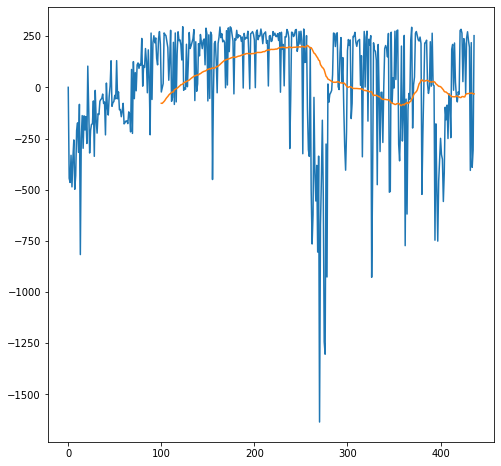

In [10]:
import gym
from gym import wrappers
from time import time
import matplotlib.pyplot as plt

if __name__ == "__main__":
    scores = []
    EPISODES = 1000
    render_every_ep = 1
    video_record_every_ep = 1
    good_episodes = None
    
    env = gym.make("LunarLander-v2")
    env = gym.wrappers.Monitor(env, "./videos/"+str(int(time()))+"/", video_callable=lambda episode_id: episode_id%video_record_every_ep==0)
    env._max_episode_steps = 4000 # changes the max steps in an episode
    
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size, good_memory=good_episodes)
    agent.gamma=0.99         # reward discount rate
    agent.epsilon=0.3        # exploration rate
    agent.epsilon_min=0.01
    agent.epsilon_decay=0.99
    agent.batch_size=32
    agent.train_start=600   # when we have this many individual memories, the training can start
    agent.memory.max_good_episodes = 3
    agent.memory.max_bad_episodes = 3
    
    graph = None#DQNPlotting()
    
    #agent.load("./models/DQN_T1604241703_R57.1_E200.h5")
    scores = run(env=env, 
                 agent=agent, 
                 EPISODES=EPISODES, 
                 render_every_ep=render_every_ep,
                 graph=graph,
                )
    '''
    
    scores = test(env=env,
                  agent=agent,
                  EPISODES=EPISODES,
                  render_every_ep=render_every_ep,
                  graph=graph
                  )
    '''



fig, ax1 = plt.subplots(1,1,figsize=(8,8))
ax1.plot(scores)
ax1.plot([np.mean(scores[i-100:i]) for i in range(len(scores))])
plt.show()

In [ ]:
import pickle

with open("good.pickle", "wb") as f:
    pickle.dump(good_episodes, f)

In [ ]:

with open("good.pickle", "rb") as f:
    a = pickle.load(f)
    
a